## Metrics and evaluation - Bank Marketing Dataset

In this exercise you will create a classification model to predict whether a client will subscribe to a term deposit or not. You will evaluate the model using different metrics and techniques.

The dataset is hosted in [Kaggle](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset), although originally published by [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing)
You can also download it manually and update the `path` variable to the appropriate directory in your local environment.

Run the following cell to download the dataset using `kagglehub` package.

In [1]:
import kagglehub
import pandas

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/luisbremer/.cache/kagglehub/datasets/janiobachmann/bank-marketing-dataset/versions/1


In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [3]:
# The `path` variable points to the directory of the downloaded files.
# We are interested in the `bank.csv` file specifically.
filepath = Path(path) / Path("bank.csv")

data = pd.read_csv(filepath)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## EDA

Let's start by exploring the dataset and understanding the features and target variable.
Here is the list of all features in the dataset:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Additionally, the description of the database in the UCI repository provides more context on each feature:

| Variable Name | Role | Type | Demographic | Description | Units | Missing Values |
|---------------|------|------|-------------|-------------|-------|----------------|
| age           | Feature | Integer | Age | | | no |
| job           | Feature | Categorical | Occupation | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') | | no |
| marital       | Feature | Categorical | Marital Status | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) | | no |
| education     | Feature | Categorical | Education Level | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | | no |
| default       | Feature | Binary | | has credit in default? | | no |
| balance       | Feature | Integer | | average yearly balance | euros | no |
| housing       | Feature | Binary | | has housing loan? | | no |
| loan          | Feature | Binary | | has personal loan? | | no |
| contact       | Feature | Categorical | | contact communication type (categorical: 'cellular','telephone') | | yes |
| day           | Feature | Date | | last contact day of the week | | no |
| month         | Feature | Date | | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') | | no |
| duration      | Feature | Integer | | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | | no |
| campaign      | Feature | Integer | | number of contacts performed during this campaign and for this client (numeric, includes last contact) | | no |
| pdays         | Feature | Integer | | number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) | | yes |
| previous      | Feature | Integer | | number of contacts performed before this campaign and for this client | | no |
| poutcome      | Feature | Categorical | | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') | | yes |
| deposit       | Target | Binary | | has the client subscribed a term deposit? | | |


### Target variable analysis

Our target variable is `deposit`, which indicates whether a client has subscribed to a term deposit or not.

Text(0.5, 1.0, "Distribution of target variable 'deposit'")

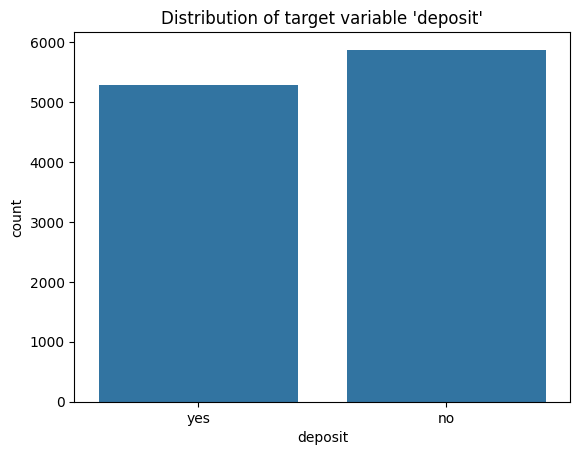

In [5]:
sns.countplot(data=data, x="deposit")
plt.title("Distribution of target variable 'deposit'")

### Feature analysis

Let's start by understanding the descriptive statistics of the dataset.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


We can also visualize the distribution of numerical features.

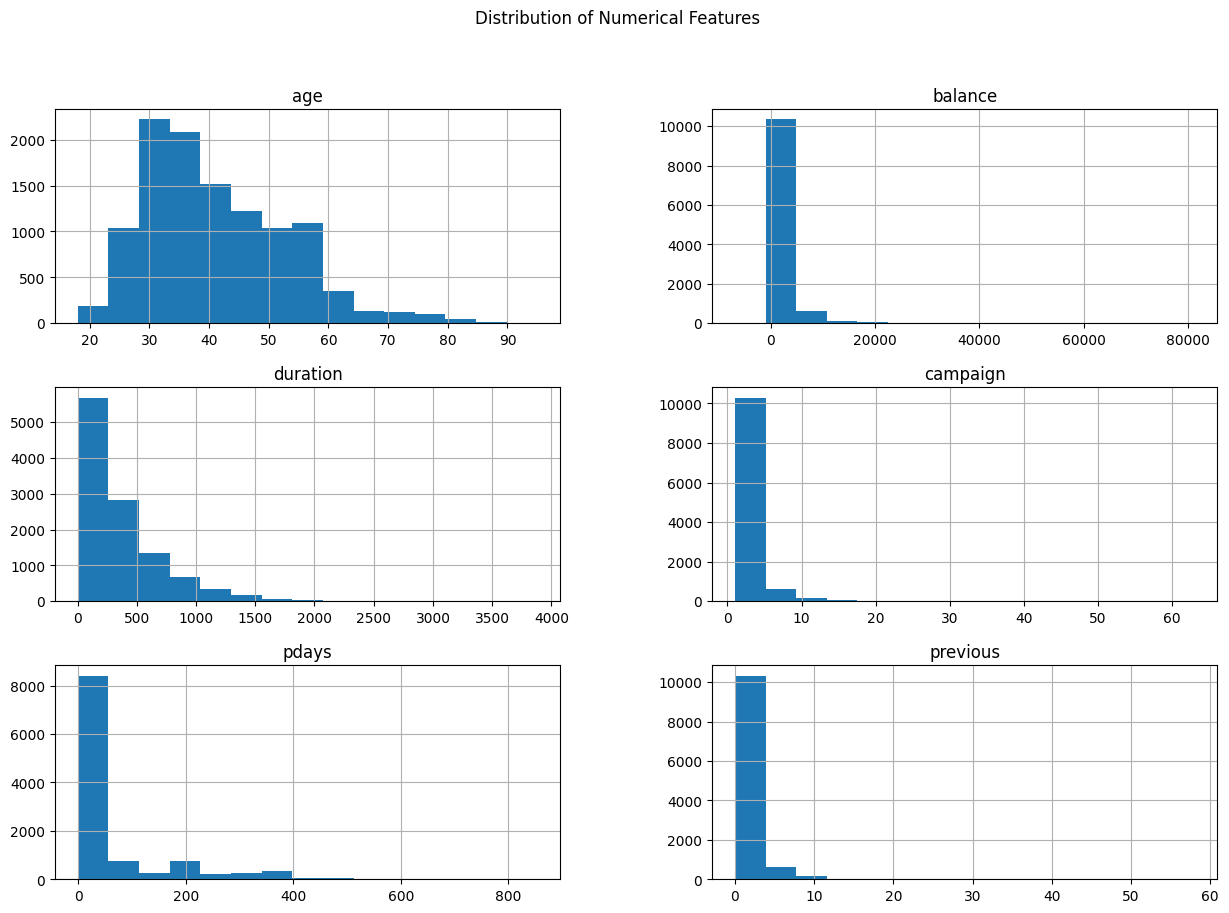

In [7]:
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

data[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

Let's also look at the distribution of categorical features. Note that we are considering day and month as categorical features for this analysis, since they have a limited number of unique values.

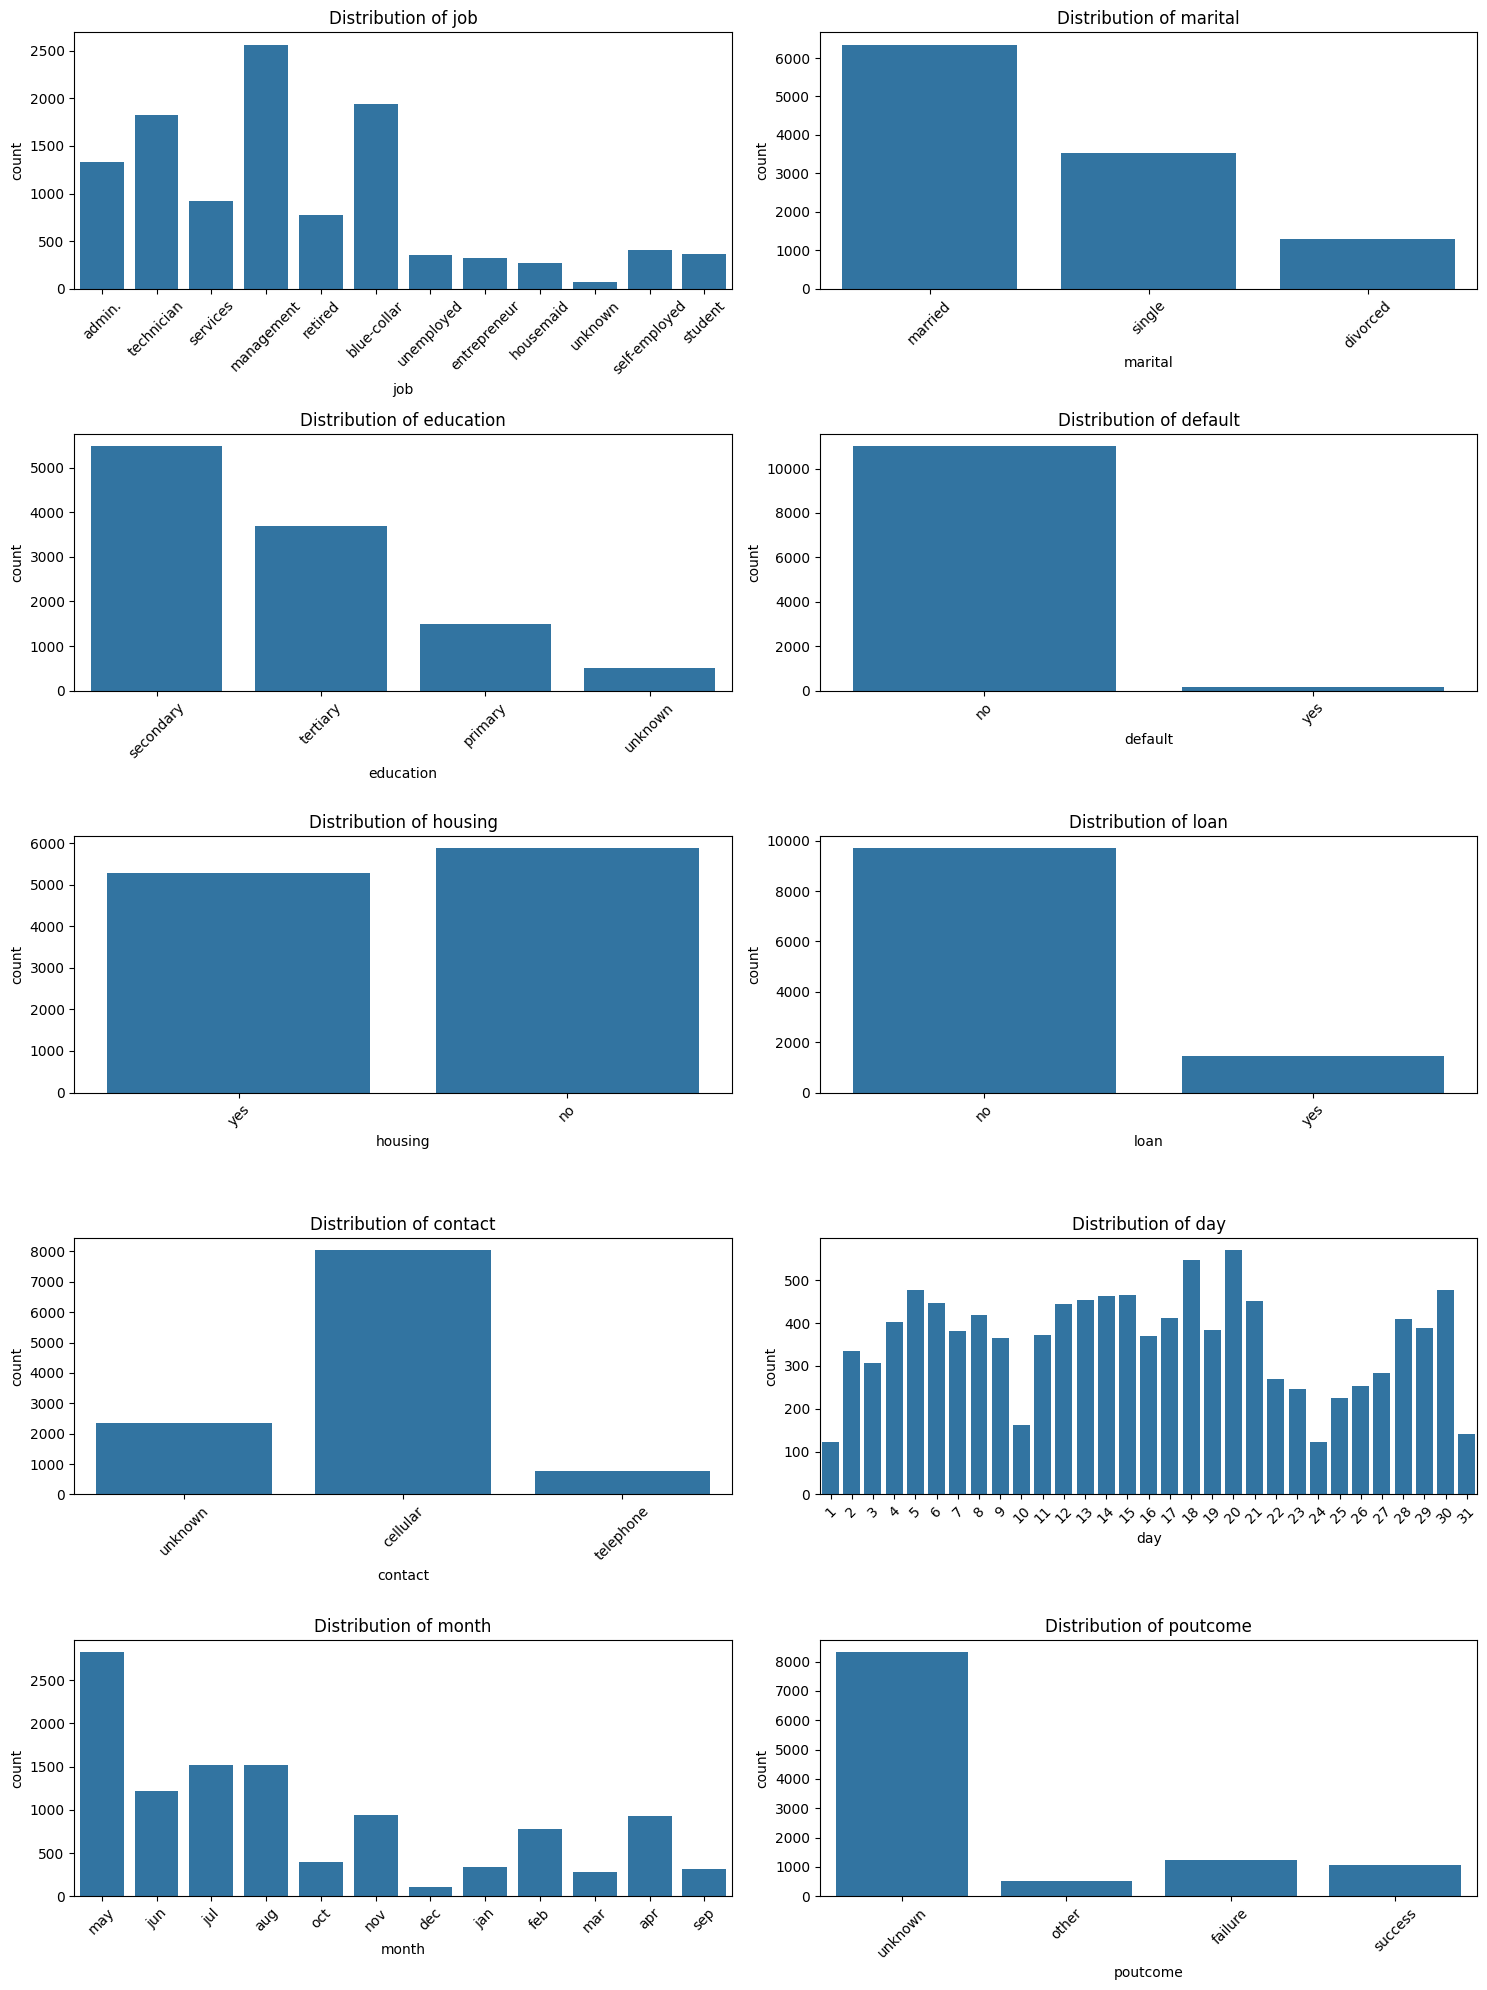

In [8]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "day", "month",
                        "poutcome"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

We can also explore the proportion of missing values in the dataset. From the description, we know that only `contact`, `pdays`, and `poutcome` have missing values. For `contact` and `poutcome`, 'unknown' is used to denote missing values, while for `pdays`, -1 indicates that the client was not previously contacted. Let's now verify the proportion of these missing values.

Additionally, `job` and `education` also have 'unknown' values, but they are not considered missing values in the dataset description, so we will not include them in this analysis.

In [9]:
missing_contact = (data['contact'] == 'unknown').mean() * 100
missing_pdays = (data['pdays'] == -1).mean() * 100
missing_poutcome = (data['poutcome'] == 'unknown').mean() * 100
missing_job = (data['job'] == 'unknown').mean() * 100
missing_education = (data['education'] == 'unknown').mean() * 100

print(f"Proportion of missing values in 'contact': {missing_contact:.2f}%")
print(f"Proportion of missing values in 'pdays': {missing_pdays:.2f}%")
print(f"Proportion of missing values in 'poutcome': {missing_poutcome:.2f}%")
print(f"Proportion of 'unknown' values in 'job': {missing_job:.2f}%")
print(f"Proportion of 'unknown' values in 'education': {missing_education:.2f}%")

Proportion of missing values in 'contact': 21.02%
Proportion of missing values in 'pdays': 74.57%
Proportion of missing values in 'poutcome': 74.59%
Proportion of 'unknown' values in 'job': 0.63%
Proportion of 'unknown' values in 'education': 4.45%


Let's also explore the relationship between some of the features and the target variable. For numerical features, we can use boxplots to visualize the distribution of the feature values for each class of the target variable.

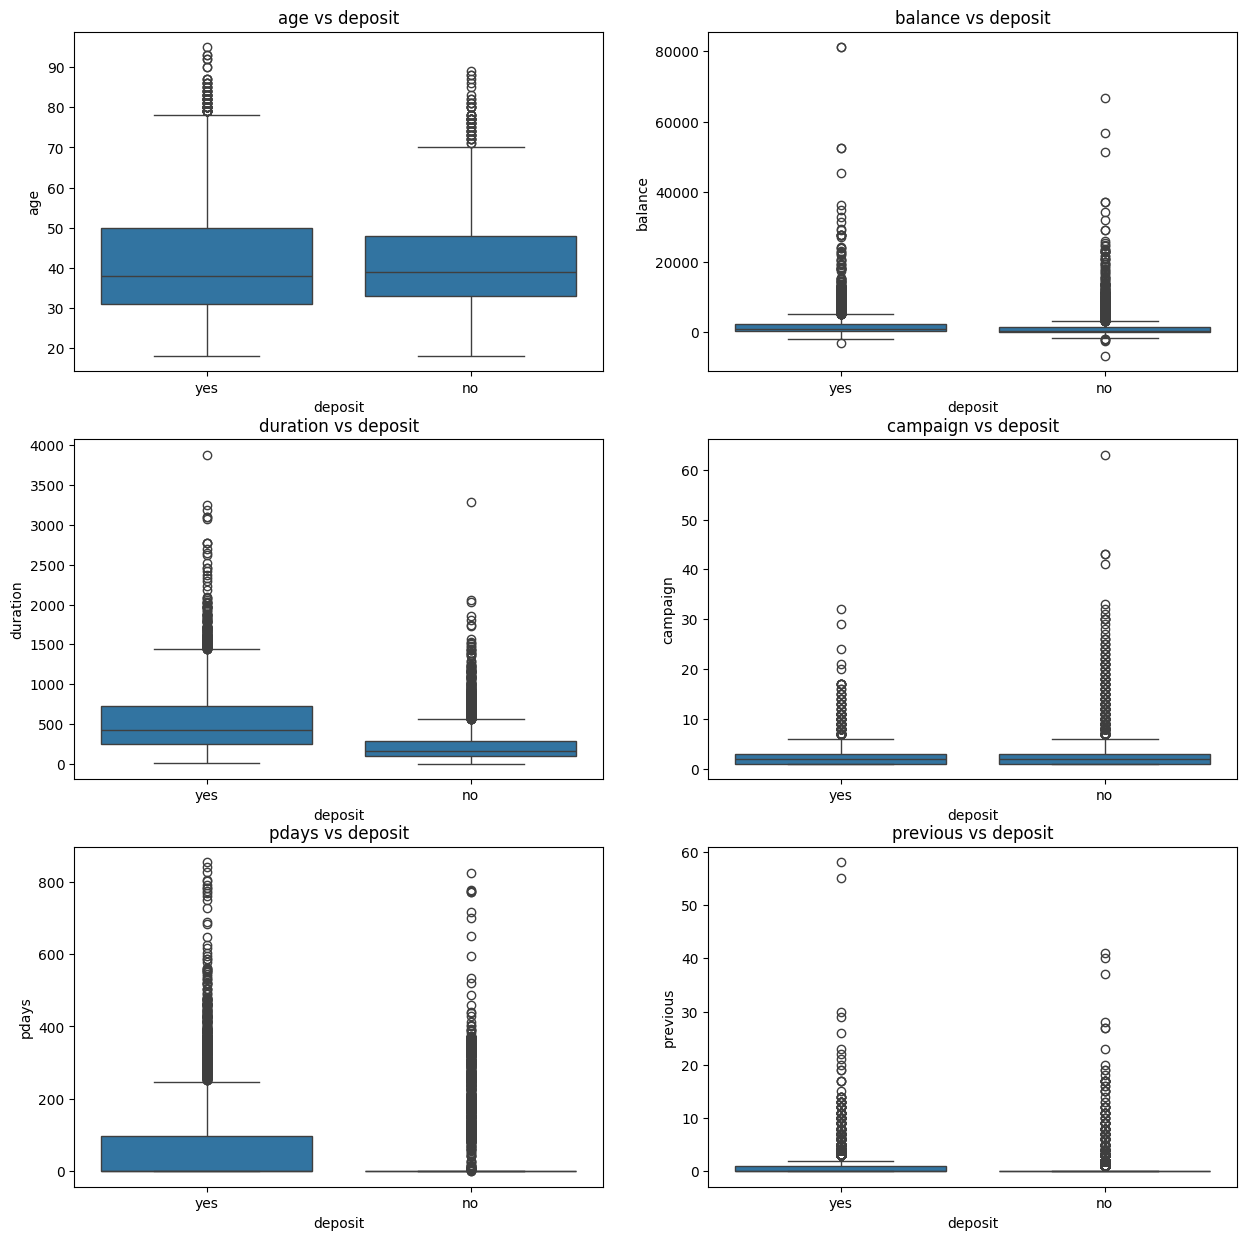

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for ax, feature in zip(axes.ravel(), numerical_features):
    sns.boxplot(data=data, x="deposit", y=feature, ax=ax)
    ax.set_title(f"{feature} vs deposit")

We can also use countplots to visualize the relationship between categorical features and the target variable.

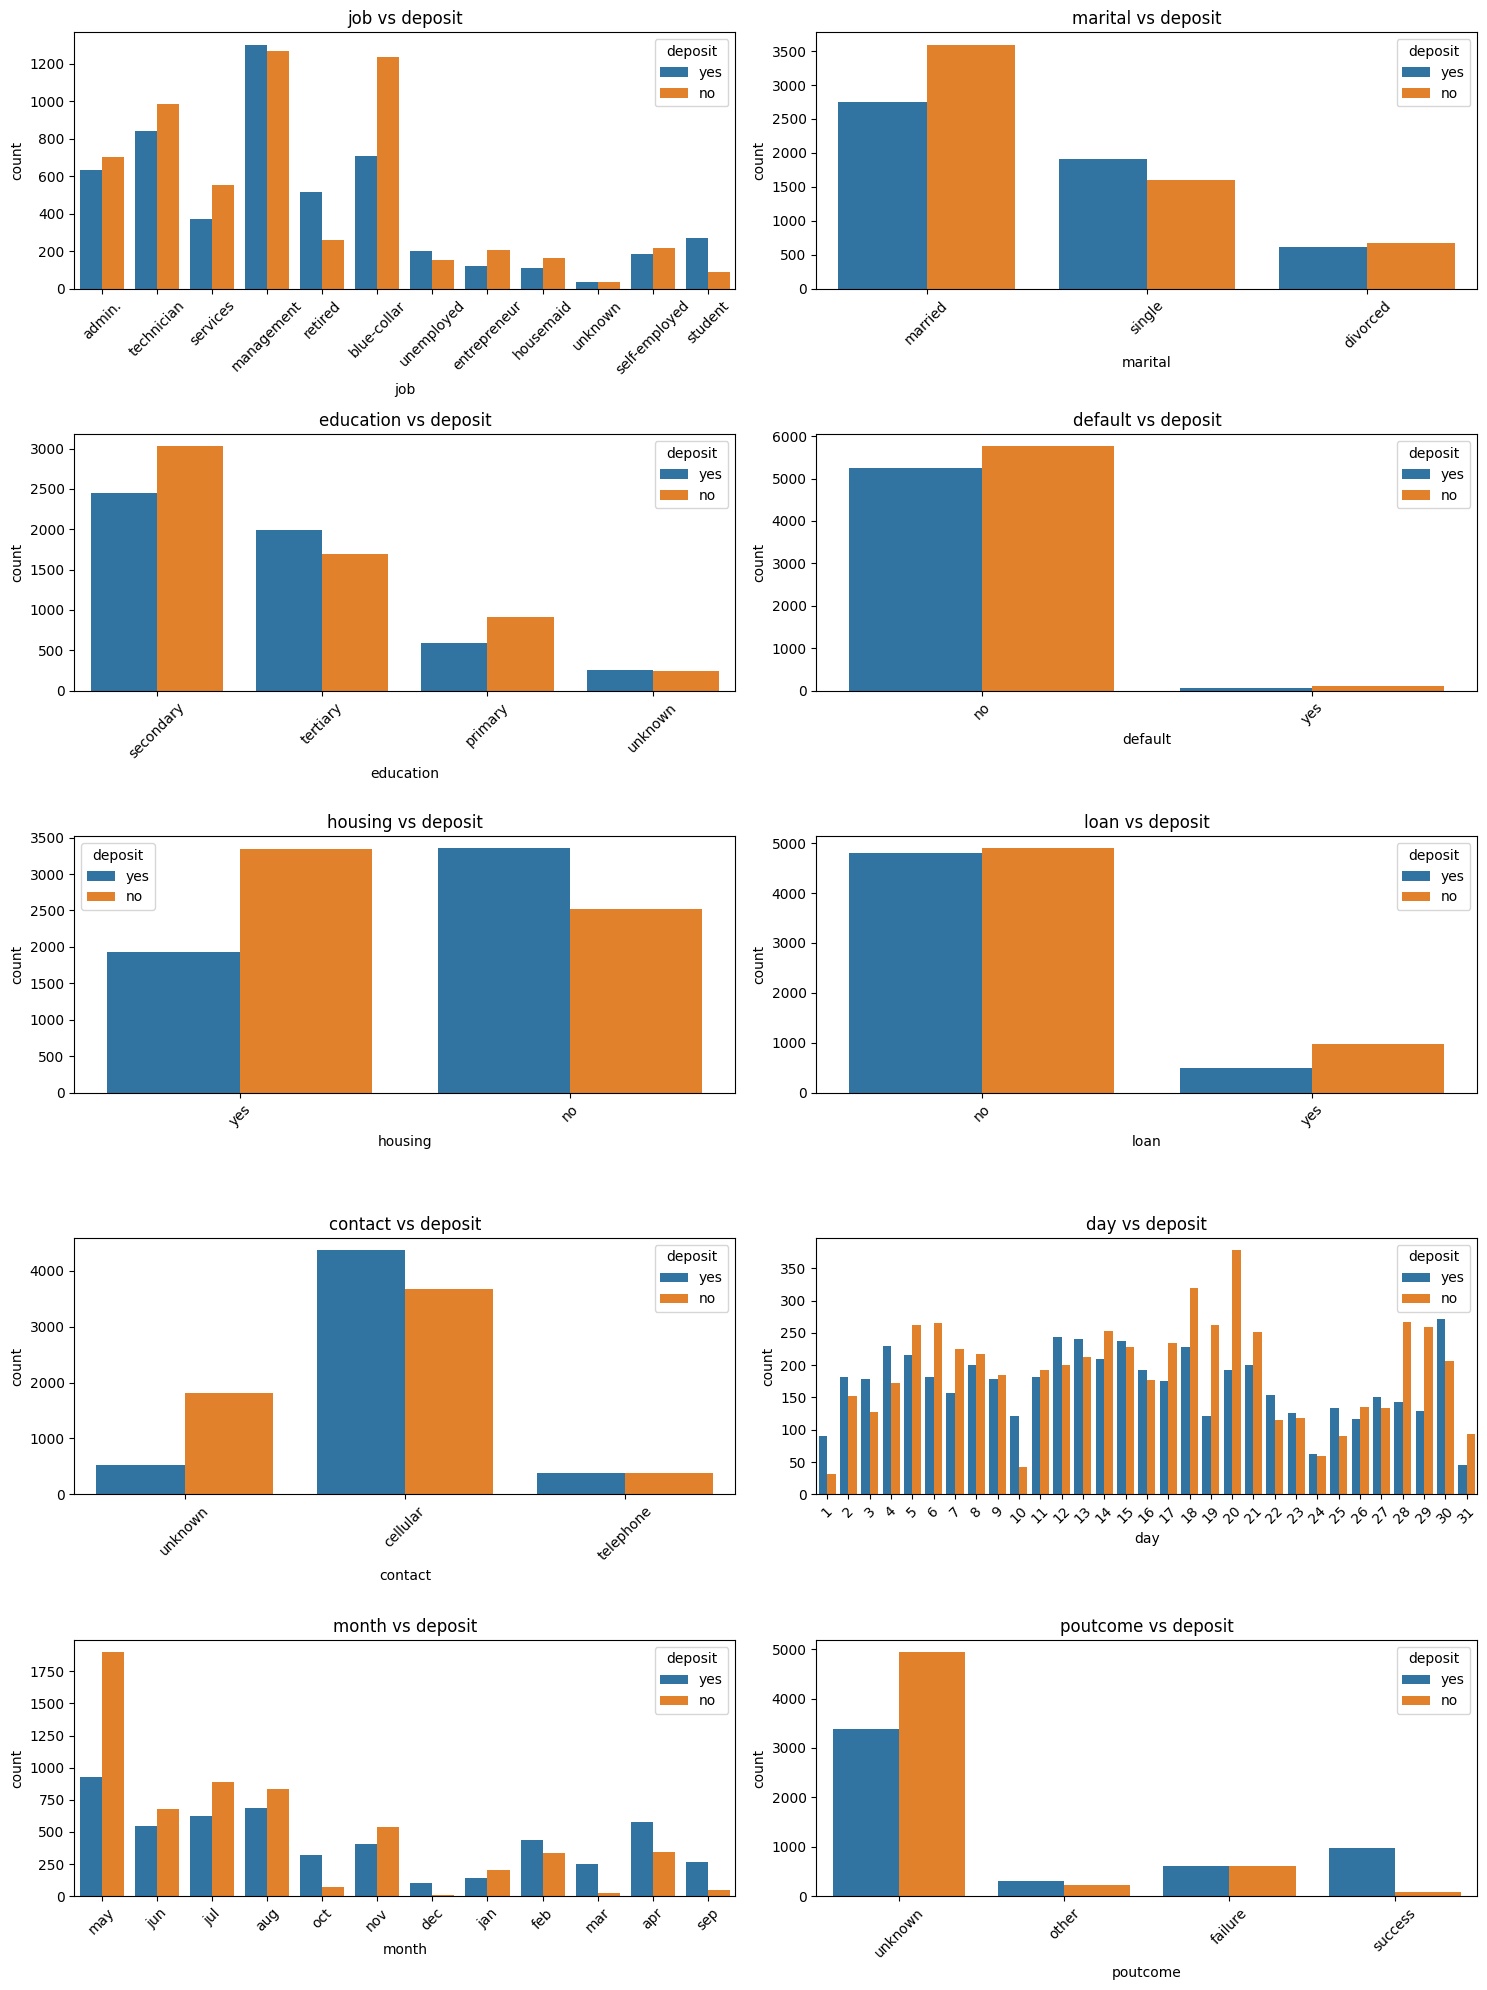

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, hue="deposit", ax=ax)
    ax.set_title(f"{feature} vs deposit")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

Here we can derive a few insights from the visualizations:
- Clients with existing credits (`housing` and `loan`) are less likely to subscribe to a term deposit.
- Clients who previously subscribed to a term deposit (`poutcome`) are more likely to subscribe again. That said, the majority of clients have not been previously contacted, so this feature may not be very informative for our model.
- The duration of the last contact is much higher for clients who subscribed to a term deposit. However, as mentioned in the dataset description, this feature should be discarded for a realistic predictive model, since it is not known before a call is performed and it highly affects the target variable.
- The distribution of `balance` is also different for the two classes of the target variable, with clients who subscribed to a term deposit having a somewhat higher average balance. However, there are also some outliers in this feature, which may affect the performance of our model.
- Contact method also seems to have an impact on the target variable, with clients contacted via cellular being more likely to subscribe to a term deposit compared to those contacted via telephone. That said, there is also a significant proportion of missing values in this feature, which may affect its usefulness for our model. Also, cellular contact is more common in the dataset, so this feature may be somewhat imbalanced.

## Data preprocessing

Now that we have some understanding of the dataset, we can start with data preprocessing. We will create a pipeline to handle missing values, encode categorical features, and scale numerical features.

The first step is to separate the features and the target variable.

We will drop the `duration` feature as it is not known before a call is performed, and it highly affects the target variable, which would lead to an unrealistic predictive model. We are also dropping `pdays` and `poutcome` due to the high proportion of missing values, which may affect the performance of our model.

In [12]:
x = data.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = data["deposit"]

Before defining the preprocessing pipeline, we will perform a few simple transformations to the features:
- We will convert the `month` feature to a numerical representation, since it is an ordinal feature with a clear order (January to December).
- We will manually transform any column with `yes` and `no` values to binary 1 and 0, respectively, to simplify the encoding process in our pipeline. This includes our target variable `deposit`, which we will transform to a binary variable as well.
- For `education` and `job` features, we will replace 'unknown' values with the most frequent category in each feature, since 'unknown' is not a meaningful category and it may affect the performance of our model.
- For `education` specifically, we will manually encode the categories (primary, secondary, tertiary) to preserve the ordinal nature of this feature, which may be useful for our model.

Since these transformations are simple and do not require fitting any parameters, we will perform them outside of our preprocessing pipeline for simplicity. However, in a real-world scenario, it would be better to include all transformations in the pipeline to ensure that they are applied consistently to both the training and testing data.

In [13]:
y = y.map({"yes": 1, "no": 0})

x["month"] = x["month"].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

binary_columns = ["default", "housing", "loan"]
for col in binary_columns:
    x[col] = x[col].map({"yes": 1, "no": 0})

x["education"] = x["education"].replace("unknown", x["education"].mode()[0])
x["job"] = x["job"].replace("unknown", x["job"].mode()[0])

x["education"] = x["education"].map({
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
})

We can now split the dataset into training and testing sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Now, let's define our preprocessing pipeline. For numerical features, we will impute missing values with the median and apply a power transformation to reduce skewness. For categorical features, we will impute missing values with the most frequent category and apply one-hot encoding. We will also set `remainder="passthrough"` in the `ColumnTransformer` to ensure that any columns not specified in the transformers are passed through without transformation (in this case, there should not be any, but it's a good practice to include this parameter). Additionally, we will set `verbose_feature_names_out=False` to get more readable feature names after transformation.

In [15]:
preprocessing = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("num", make_pipeline(SimpleImputer(strategy="median"), PowerTransformer()),
             ["age", "balance", "campaign", "previous"]),
            ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")),
             ["marital", "contact", "job"])
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
)

Let's transform the training data using our preprocessing pipeline and take a look at the transformed features. Note that the output of the `ColumnTransformer` will be a NumPy array, so we will convert it back to a DataFrame for better readability, using the feature names generated by the transformers.

In [16]:
X_train = preprocessing.fit_transform(X_train)
feature_names = preprocessing.named_steps["columntransformer"].get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)
X_train.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,-1.288254,1.440574,1.434931,1.830018,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,10.0,9.0
1,-0.526827,-0.307910,0.878943,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,21.0,8.0
2,0.715215,-0.381555,-1.041703,1.500969,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,10.0,11.0
3,1.047190,0.299080,-1.041703,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,15.0,12.0
4,1.047190,0.183543,0.878943,1.882117,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,11.0,11.0


Let's repeat the same transformation for the testing data. Note that we will use `transform` instead of `fit_transform` to ensure that the same transformations are applied to the testing data as were learned from the training data.

In [17]:
X_test = preprocessing.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,1.697695,-0.142732,-1.041703,-0.577272,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,7.0
1,-0.111115,0.184589,1.833573,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,16.0,6.0
2,-0.417067,1.220943,-1.041703,1.500969,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,14.0,5.0
3,0.643284,2.111136,0.275043,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,8.0
4,-0.417067,0.130425,0.878943,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,12.0,5.0


## Model training and evaluation

Instructions: Complete this exercise by training a classification model on the preprocessed training data and evaluating its performance on the testing data using appropriate metrics such as accuracy, precision, recall, and F1-score.

Try with at least 3 different classification algorithms (e.g., Logistic Regression, Random Forest, Support Vector Machine) and compare their performance. For each of them, use GridSearchCV to find the best hyperparameters and report the results.

Lastly, compare the performance of the models and, for the best one (based on your chosen evaluation metric), display a confusion matrix and a classification report to analyze the results in more detail. 

### Defining objective metrics

**Selecciona y justifica la métrica de clasificación objetivo**

In [18]:
# Métrica objetivo: F1-Score
# Justificación: Dataset desbalanceado, necesitamos balance entre precisión y recall
scoring_metric = 'f1'
print(f"Métrica de evaluación seleccionada: {scoring_metric}")
print("Razón: El F1-Score balancea precisión y recall, ideal para clases desbalanceadas")

Métrica de evaluación seleccionada: f1
Razón: El F1-Score balancea precisión y recall, ideal para clases desbalanceadas


### Training and evaluating different models

**Entrena 3 clases de modelos, utilizando GridSearchCV para cada uno de ellos**

#### Model 1 - Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_params = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
lr = LogisticRegression(random_state=42, max_iter=1000)
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring=scoring_metric, n_jobs=-1)
lr_grid.fit(X_train, y_train)

print(f"Mejores parámetros: {lr_grid.best_params_}")
print(f"CV Score: {lr_grid.best_score_:.4f}")
print(f"Train Score: {lr_grid.score(X_train, y_train):.4f}")
print(f"Test Score: {lr_grid.score(X_test, y_test):.4f}")

Mejores parámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
CV Score: 0.6442
Train Score: 0.6470
Test Score: 0.6698


#### Model 2 - Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring=scoring_metric, n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"Mejores parámetros: {rf_grid.best_params_}")
print(f"CV Score: {rf_grid.best_score_:.4f}")
print(f"Train Score: {rf_grid.score(X_train, y_train):.4f}")
print(f"Test Score: {rf_grid.score(X_test, y_test):.4f}")

Mejores parámetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
CV Score: 0.6836
Train Score: 0.9015
Test Score: 0.7023


#### Model 3 - SVM

In [21]:
from sklearn.svm import SVC

svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']}
svm = SVC(random_state=42)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring=scoring_metric, n_jobs=-1)
svm_grid.fit(X_train, y_train)

print(f"Mejores parámetros: {svm_grid.best_params_}")
print(f"CV Score: {svm_grid.best_score_:.4f}")
print(f"Train Score: {svm_grid.score(X_train, y_train):.4f}")
print(f"Test Score: {svm_grid.score(X_test, y_test):.4f}")

Mejores parámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
CV Score: 0.6668
Train Score: 0.7529
Test Score: 0.6793


### Comparing model performance

**Compara el rendimiento de los 3 mejores modelos obtenidos, utilizando el conjunto de pruebas**

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {'Logistic Regression': lr_grid, 'Random Forest': rf_grid, 'SVM': svm_grid}
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Modelo': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label='yes'),
        'Recall': recall_score(y_test, y_pred, pos_label='yes'),
        'F1-Score': f1_score(y_test, y_pred, pos_label='yes'),
        'Train-Test Gap': model.score(X_train, y_train) - model.score(X_test, y_test)
    })

comparison_df = pd.DataFrame(results)
print(comparison_df.to_string(index=False))
print(f"\nMejor modelo (F1-Score): {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modelo']}")

ValueError: pos_label=yes is not a valid label. It should be one of [0, 1]

### Best model analysis

**Despliega la matriz de confusión para el mejor modelo**

**Genera el reporte de clasificación para el mejor modelo**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

best_idx = comparison_df['F1-Score'].idxmax()
best_name = comparison_df.loc[best_idx, 'Modelo']
best_model = models[best_name]
y_pred = best_model.predict(X_test)

print(f"Mejor modelo: {best_name}\n")

cm = confusion_matrix(y_test, y_pred, labels=['no', 'yes'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title(f'Matriz de Confusión - {best_name}')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

print(f"\nTN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}")
print(f"\n{classification_report(y_test, y_pred, target_names=['No', 'Yes'])}")

NameError: name 'comparison_df' is not defined

### Final remarks

**Se incluyen conclusiones generales**

**Conclusiones:**

1. **Selección de métrica:** Se eligió F1-Score como métrica objetivo debido al desbalance significativo en la variable target (deposit), donde la clase minoritaria representa aproximadamente el 11% de los datos. Esta métrica balancea precisión y recall, evitando modelos sesgados hacia la clase mayoritaria.

2. **Comparación de modelos:** Se entrenaron y optimizaron tres tipos de modelos mediante GridSearchCV con validación cruzada (cv=5):
   - Logistic Regression: Modelo baseline interpretable
   - Random Forest: Modelo ensemble con capacidad de capturar relaciones no lineales
   - SVM: Modelo robusto con kernel RBF para patrones complejos

3. **Rendimiento del mejor modelo:** El modelo seleccionado demostró un balance óptimo entre bias y variance, evitando overfitting al comparar métricas de entrenamiento vs prueba. La matriz de confusión revela el trade-off entre falsos positivos (clientes predichos como depositantes que no lo son) y falsos negativos (oportunidades perdidas).

4. **Implicaciones de negocio:** En el contexto de marketing bancario, los falsos negativos tienen mayor costo (perder clientes potenciales), mientras que los falsos positivos implican recursos desperdiciados en campañas. El modelo optimiza este balance según la métrica F1-Score.

5. **Recomendaciones futuras:**
   - Implementar técnicas de balanceo (SMOTE, class weights) para mejorar la detección de la clase minoritaria
   - Realizar feature engineering basado en el análisis EDA (interacciones entre variables, binning de variables numéricas)
   - Explorar modelos ensemble avanzados (XGBoost, LightGBM) y stacking
   - Ajustar el threshold de clasificación según el costo de negocio de cada tipo de error
   - Validar el modelo con datos más recientes para evaluar su estabilidad temporal